In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',family = 'Malgun Gothic')
plt.rc('axes',unicode_minus = False)
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1) 데이터 로드하기

In [75]:
train = pd.read_table('ratings_train.txt')
test = pd.read_table('ratings_test.txt')

### 1-1. 타겟데이터 파악

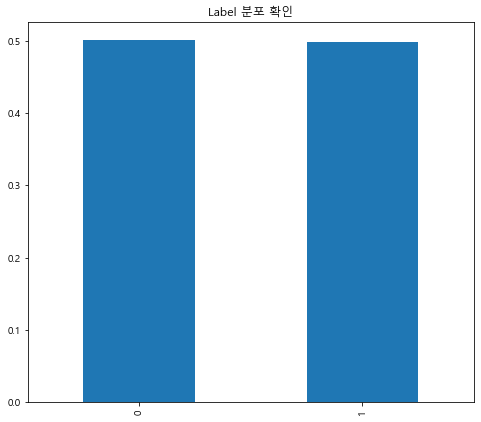

In [16]:
plt.figure(figsize = (8,7))
plt.title('Label 분포 확인')
train['label'].value_counts(normalize = True).plot.bar()
plt.show()

### 1-2. 중복여부 파악

In [20]:
len(train),train['document'].nunique()

(150000, 146182)

- 중복 데이터가 4000개 정도 존재한다.

In [77]:
train = train.drop_duplicates(subset = ['document']).reset_index(drop = True)

In [24]:
len(test),test['document'].nunique()

(50000, 49157)

- 테스트 데이터에도 850개정도 중복이 존재하므로 제거한다.

In [78]:
test = test.drop_duplicates(subset=['document']).reset_index(drop = True)

### 1-3. Null값 여부 파악

In [33]:
train.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146183 entries, 0 to 146182
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146183 non-null  int64 
 1   document  146182 non-null  object
 2   label     146183 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.3+ MB


- 1개 정도의 null값을 보이고 있다.

In [34]:
train.loc[train['document'].isnull()]

,id,document,label
25521,2172111,NaN,1


In [79]:
train = train.dropna().reset_index(drop = True)

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146182 entries, 0 to 146181
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.3+ MB


- train 데이터에는 이제 결측값과 중복값이 없다.

In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49158 entries, 0 to 49157
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49158 non-null  int64 
 1   document  49157 non-null  object
 2   label     49158 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [40]:
test.isnull().sum()

id          0
document    1
label       0
dtype: int64

- 테스트 데이터에도 하나의 결측값이 존재한다.

In [41]:
test.loc[test['document'].isnull()]

,id,document,label
5704,402110,NaN,1


In [80]:
test = test.dropna().reset_index(drop = True)

In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49157 entries, 0 to 49156
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49157 non-null  int64 
 1   document  49157 non-null  object
 2   label     49157 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


- test 데이터에는 이제 중복, 결측값이 존재하지 않는다.

### 2. 정규표현식을 통해 필요없는 문자들 제거

- 한글과 공백을 제외하고 제거하기

In [81]:
train['document'] = train['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')

test['document'] = test['document'].str.replace('[^ ㄱ-ㅎㅏ-ㅣ가-힣]','')

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
train.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [55]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


- 위의 테스트 데이터에도 보이듯이 빈칸만 있는 데이터들이 존재할 수 있다. -> 이 것들을 파악하고 제거하는 것이 좋을 듯하다.

In [82]:
train['document'] = train['document'].str.replace('^ +','')
test['document'] = test['document'].str.replace('^ +','')

train['document'].replace('',np.nan,inplace = True)

test['document'].replace('',np.nan,inplace = True)

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [67]:
train['document'].isnull().sum(),test['document'].isnull().sum()

(789, 305)

In [83]:
train = train.dropna().reset_index(drop = True)
test = test.dropna().reset_index(drop = True)

In [84]:
train.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [85]:
test.isnull().sum()

id          0
document    0
label       0
dtype: int64

## 3) 토큰화

### 3-1. 불용어 제거하기

In [86]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

okt = Okt()

In [89]:
X_train = []
for sentence in train['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

X_test = []
for sentence in test['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [92]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

## 4) 정수 인코딩

In [94]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

In [104]:
len(tokenizer.word_index)

43752

- 단어가 43752개로 많음 -> 빈도수를 파악하여 빈도수가 적은 데이터들은 제거를 하는 것이 좋다.

In [105]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [106]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

단어 집합의 크기 : 19416


In [110]:
y_train = np.array(train['label'])
y_test = np.array(test['label'])

## 5) 빈 샘플(empty samples) 제거

- 빈도수가 낮은 데이터를 삭제하였으므로 빈도수가 낮은 데이터들로 구성되었던 것들은 아무것도 값을 가지고 있지 않을 것이다. 그래서 파악한 후 제거

In [120]:
drop_idx = [idx for idx,values in enumerate(X_train) if len(values)==0]

X_train = np.delete(X_train,drop_idx,axis = 0)
y_train = np.delete(y_train,drop_idx,axis = 0)

## 6) 패딩 작업

In [131]:
X_train

array([list([50, 454, 16, 260, 659]),
       list([933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19]),
       list([386, 2444, 2315, 5671, 2, 222, 9]), ...,
       list([38, 59, 55, 1448, 5601, 14629, 44, 10465, 10401, 1043]),
       list([1039, 1, 2265, 2930, 1224, 540, 7848]),
       list([196, 1, 1814, 17, 58, 1357, 1])], dtype=object)

X_train의 리뷰 최대 길이 : 69
X_train의 리뷰 평균 길이 : 10.812485361182679


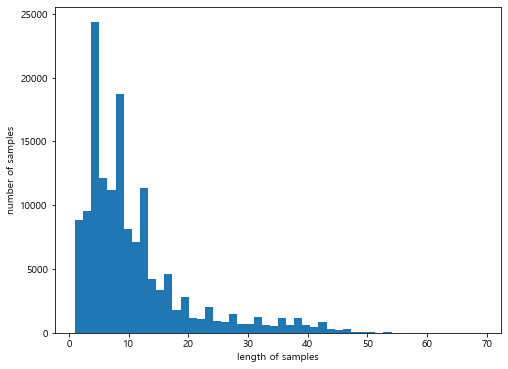

In [149]:
print('X_train의 리뷰 최대 길이 :',max(len(l) for l in X_train))

print("X_train의 리뷰 평균 길이 :",sum(map(len, X_train))/len(X_train))

plt.figure(figsize = (8,6))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 가장 긴 리뷰의 길이는 69이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 11내외의 길이를 가지는 것을 볼 수 있다.
- 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있다.

In [153]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [160]:
below_threshold_len(32,X_train)

전체 샘플 중 길이가 32 이하인 샘플의 비율: 95.1667791846351


- 32로 맞추면 95%정도 비율이 맞춰지므로 max_len의 기준을 32로 한다.
- 패딩을 할 때 0값은 뒤로 넣어줄 것이다.(padding = 'post')
- 만약 앞에 0을 넣어주고 싶다면 padding = 'pre'를 사용하면 된다.

In [161]:
X_train = pad_sequences(X_train,maxlen=32,padding='post')
X_test = pad_sequences(X_test,maxlen=32,padding='post')

# 2. LSTM으로 네이버 영화 리뷰 감성 분류하기

In [164]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [168]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

- 벡터 차원은 100으로 

In [173]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

- EarlyStopping을 통해 과적합을 방지하고 ModelCheckpoint를 통해 좋은 모델 저장

In [171]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

In [175]:
history = model.fit(X_train,y_train,epochs=15,batch_size=60,validation_split=0.2,callbacks=[es,mc])

Epoch 1/15
1936/1936 [==============================] - 24s 12ms/step - loss: 0.3854 - acc: 0.8305 - val_loss: 0.3727 - val_acc: 0.8411

Epoch 00001: val_acc improved from -inf to 0.84108, saving model to best_model.h5
Epoch 2/15
1936/1936 [==============================] - 23s 12ms/step - loss: 0.3372 - acc: 0.8556 - val_loss: 0.3471 - val_acc: 0.8498

Epoch 00002: val_acc improved from 0.84108 to 0.84976, saving model to best_model.h5
Epoch 3/15
1936/1936 [==============================] - 25s 13ms/step - loss: 0.3099 - acc: 0.8693 - val_loss: 0.3354 - val_acc: 0.8538

Epoch 00003: val_acc improved from 0.84976 to 0.85375, saving model to best_model.h5
Epoch 4/15
1936/1936 [==============================] - 25s 13ms/step - loss: 0.2904 - acc: 0.8797 - val_loss: 0.3279 - val_acc: 0.8592

Epoch 00004: val_acc improved from 0.85375 to 0.85916, saving model to best_model.h5
Epoch 5/15
1936/1936 [==============================] - 26s 13ms/step - loss: 0.2750 - acc: 0.8869 - val_loss: 0.33

In [176]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 6s 4ms/step - loss: 0.3348 - acc: 0.8547

 테스트 정확도: 0.8547


# 3. 리뷰 예측해보기 

In [198]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = 32) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [199]:
sentiment_predict('이 영화 개씹노잼')

68.98% 확률로 부정 리뷰입니다.

